In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.mcmc.util import summary
from palmerpenguins import load_penguins
plt.style.use('ggplot')

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Chapter 3

In [2]:
penguins = load_penguins()
penguins.dropna(how='any', axis=0, inplace=True)

In [250]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [3]:
adelie_mask = (penguins['species'] == 'Adelie')
adelie_mass_obs = torch.from_numpy(penguins.loc[adelie_mask, 'body_mass_g'].values)

### Code 3.3

In [252]:
def model_prior(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

In [253]:
#  prior predictive --> mu and sigma
samples = Predictive(
    model_prior, {}, num_samples=1000, return_sites=['sigma', 'mu', 'mass'])(adelie_mass_obs)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/data/base.py:220: UserWarning: More chains (1000) than draws (146). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8999dc7e20>]],
      dtype=object)

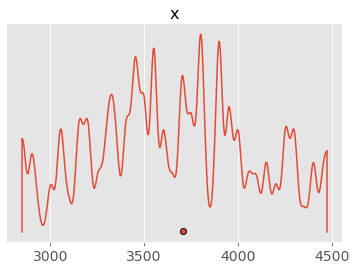

In [254]:
az.plot_density(data=samples['mass'].numpy())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8999eaa760>]],
      dtype=object)

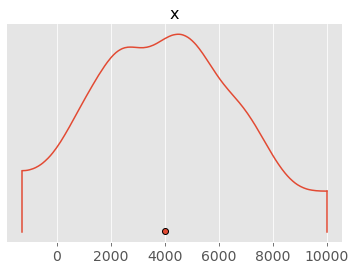

In [255]:
az.plot_density(data=samples['mu'].numpy())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8999c94610>]],
      dtype=object)

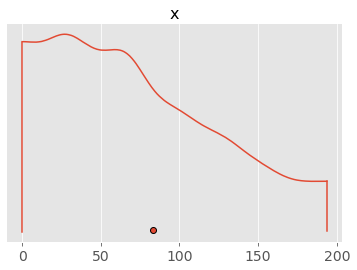

In [256]:
az.plot_density(data=samples['sigma'].numpy())

In [257]:
def model(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

    return mass

In [258]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=2000, warmup_steps=1000)
mcmc.run(obs=adelie_mass_obs)

Sample: 100%|██████████| 3000/3000 [00:45, 65.22it/s, step size=8.76e-01, acc. prob=0.923] 


In [259]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu   3707.17     35.34   3707.04   3647.83   3760.54   1456.99      1.00
     sigma    435.63     23.75    434.81    396.92    473.06   1490.52      1.00

Number of divergences: 0


In [260]:
samples_1 = mcmc.get_samples()

In [261]:
samples_1

{'mu': tensor([3730.0934, 3713.2198, 3764.2792,  ..., 3715.3029, 3709.2097,
         3747.3848], dtype=torch.float64),
 'sigma': tensor([411.5391, 438.3062, 438.7027,  ..., 437.0136, 426.0214, 453.0109],
        dtype=torch.float64)}

## 3.2.1 Linear Penguins

In [4]:
adelie_flipper_length = torch.from_numpy(penguins.loc[adelie_mask, 'flipper_length_mm'].values)
adelie_mass = torch.from_numpy(penguins.loc[adelie_mask, 'body_mass_g'].values)

In [5]:
def linear_model(flipper_length, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 4000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 4000.))
    mu = pyro.deterministic('mu', beta_0 + beta_1 * flipper_length)

    with pyro.plate('plate'):   
        preds = pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)  

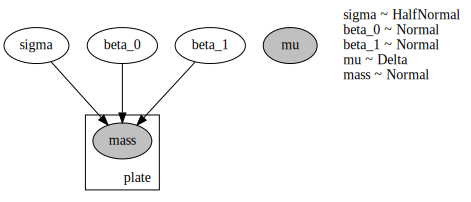

In [264]:
pyro.render_model(
    linear_model, 
    model_args=(adelie_flipper_length, adelie_mass),
    render_distributions=True
    )

### MCMC

- `mcmc` = fitted MCMC object
- `mcmc_samples` = only the latent variables are returned via the `.get_samples()` method
    - `mu` is not returned in the `mcmc.get_samples()` dict
    - deterministic parts are only available via the `Predictive` function. Similarily, observed samples is only available via this function too 

In [265]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    
    return site_stats

In [266]:
kernel = NUTS(linear_model, adapt_step_size=True)
mcmc_simple = MCMC(kernel, num_samples=500, warmup_steps=300)
mcmc_simple.run(flipper_length=adelie_flipper_length, mass=adelie_mass)

Sample: 100%|██████████| 800/800 [02:06,  6.32it/s, step size=2.32e-02, acc. prob=0.948]


In [267]:
mcmc_simple.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0  -2441.18    930.96  -2449.14  -3991.38   -986.24    166.43      1.00
    beta_1     32.34      4.90     32.25     24.53     40.44    167.01      1.00
     sigma    392.16     20.51    390.22    355.86    422.31    229.88      1.01

Number of divergences: 0


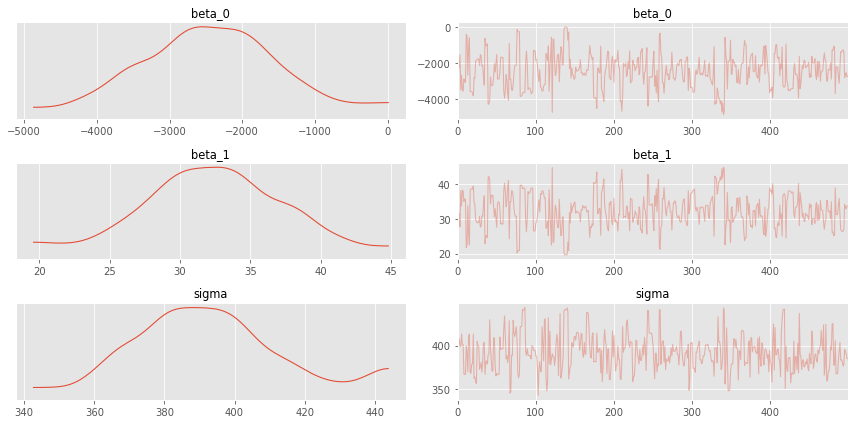

In [268]:
# trace plots are interesting for only only chain
az.plot_trace(az.from_pyro(mcmc_simple))
plt.tight_layout()

#### Posterior Predictive Distribution

Sample mass and mu from posterior. 

In [269]:
# latent variables
mcmc_samples = mcmc_simple.get_samples(num_samples=1000)
# posterior samples 
predictive = Predictive(linear_model, mcmc_samples)
# latent variables: 
predictive_samples = predictive(flipper_length=adelie_flipper_length, mass=None) 

for k, v in predictive_samples.items():
    print(f'{k}: {tuple(v.shape)}')

mass: (1000, 146)
mu: (1000, 1, 146)


In [270]:
def mcmc_fit(predictive):
    mass = predictive['mass']
    mass_mu = mass.mean(axis=0)
    mass_std = mass.std(axis=0)

    mass_df = pd.DataFrame({
        'feat': adelie_flipper_length,
        'mean': mass_mu,
        'high': mass_mu + mass_std,
        'low': mass_mu - mass_std}
    )

    return mass_df.sort_values(by=['feat'])

In [271]:
mass_df = mcmc_fit(predictive=predictive_samples)

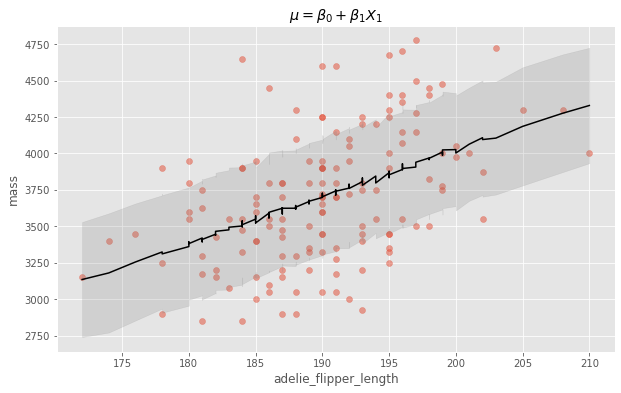

In [272]:
plt.figure(figsize=(10, 6))
plt.scatter(adelie_flipper_length.numpy(), adelie_mass.numpy(), alpha=0.5)
plt.plot(mass_df['feat'], mass_df['mean'], color='black')
plt.fill_between(
    mass_df['feat'], mass_df['high'], mass_df['low'], alpha=0.2, color='grey')
plt.xlabel('adelie_flipper_length')
plt.ylabel('mass')
plt.title('$\mu =  \\beta_0 + \\beta_1X_1$')
plt.show()

### SVI

Using SVI for a simple linear regression like this is probably overkill, but lets do it anyways.

For the surrogate, we use the predefined `AutoNormal`

**NOT WORKING: I believe it has to do with the autoguide. Solution could be to implement the guide by hand**

pyro.get_param_store() is comprised of learned parameters that will be used in the `Predictive` stage. Instead of providing samples, the `guide` parameter is used to construct the posterior predictive distribution

## 3.3 Multiple Linear Regression

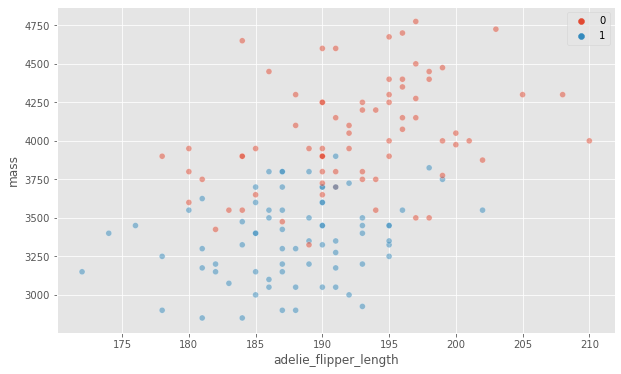

In [6]:
sex_obs = torch.from_numpy(penguins.loc[adelie_mask, 'sex'].replace({'male': 0, 'female': 1}).values)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=adelie_flipper_length, y=adelie_mass_obs, hue=sex_obs, alpha=0.5)
plt.xlabel('adelie_flipper_length')
plt.ylabel('mass')
plt.show()

In [280]:
def linear_model(flipper_length, sex, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 3000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 3000.))
    beta_2 = pyro.sample('beta_2', dist.Normal(0., 3000.))
    mu = pyro.deterministic('mu', beta_0 + beta_1 * flipper_length + beta_2 * sex)

    with pyro.plate('plate'):   
        preds = pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)  

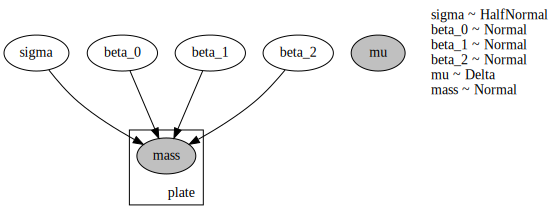

In [281]:
pyro.render_model(
    linear_model, 
    model_args=(adelie_flipper_length, sex_obs, adelie_mass),
    render_distributions=True
    )

### MCMC

In [282]:
kernel = NUTS(linear_model, adapt_step_size=True)
mcmc = MCMC(kernel, num_samples=500, warmup_steps=300, num_chains=1)
mcmc.run(flipper_length=adelie_flipper_length, sex=sex_obs, mass=adelie_mass)

Sample: 100%|██████████| 800/800 [02:39,  5.03it/s, step size=2.93e-02, acc. prob=0.940]


In [283]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0    858.30    705.14    822.31   -317.98   1788.14    141.47      1.00
    beta_1     16.55      3.66     16.76     11.60     22.51    142.56      1.00
    beta_2   -596.87     47.02   -596.83   -674.49   -519.23    362.03      1.00
     sigma    288.38     16.31    286.80    261.90    313.87    301.37      1.00

Number of divergences: 0


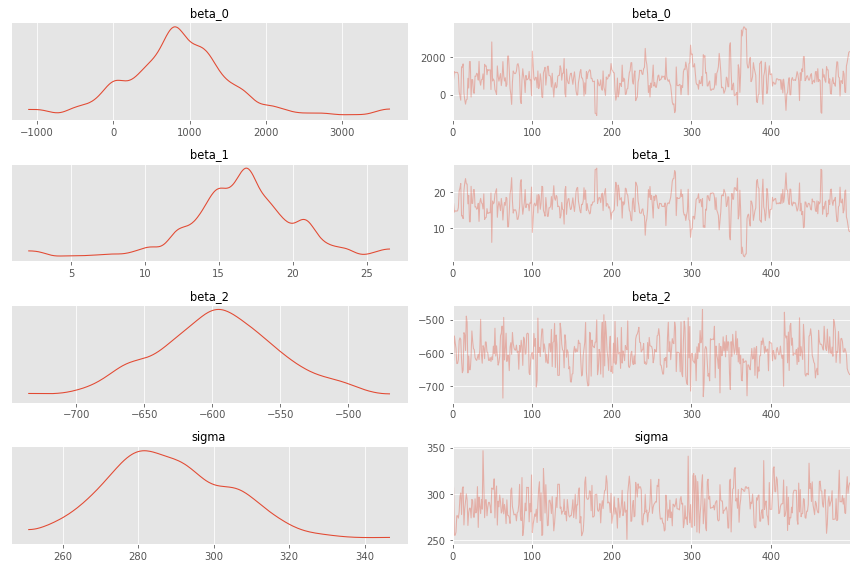

In [284]:
az.plot_trace(az.from_pyro(mcmc))
plt.tight_layout()

In [285]:
# latent variables
mcmc_samples = mcmc.get_samples(num_samples=1000)
# posterior samples 
predictive = Predictive(linear_model, mcmc_samples)
# posterior predictive
predictive_samples = predictive(flipper_length=adelie_flipper_length, sex=sex_obs, mass=None) 

for k, v in predictive_samples.items():
    print(f'{k}: {tuple(v.shape)}')

mass: (1000, 146)
mu: (1000, 1, 146)


In [286]:
mass_mu = predictive_samples['mass'].numpy().mean(axis=0)
mass_std = predictive_samples['mass'].numpy().std(axis=0)

predictions = pd.DataFrame({
    'sex': sex_obs,
    'flipper': adelie_flipper_length,
    'mass_mu': mass_mu,
    'mass_std': mass_std,
    'high': mass_mu + mass_std,
    'low': mass_mu - mass_std
})

predictions = predictions.sort_values(by=['flipper'])

In [287]:
male = predictions[predictions['sex'] == 0]
female = predictions[predictions['sex'] == 1]

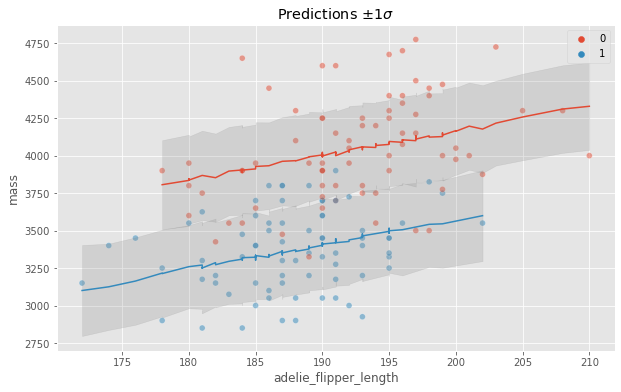

In [288]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=adelie_flipper_length, y=adelie_mass_obs, hue=sex_obs, alpha=0.5)
plt.plot(male['flipper'], male['mass_mu'])
plt.plot(female['flipper'], female['mass_mu'])
plt.fill_between(
    male['flipper'], male['high'], male['low'], alpha=0.2, color='grey')
plt.fill_between(
    female['flipper'], female['high'], female['low'], alpha=0.2, color='grey')
plt.xlabel('adelie_flipper_length')
plt.ylabel('mass')
plt.title('Predictions $\pm 1 \sigma$ ')
plt.show()

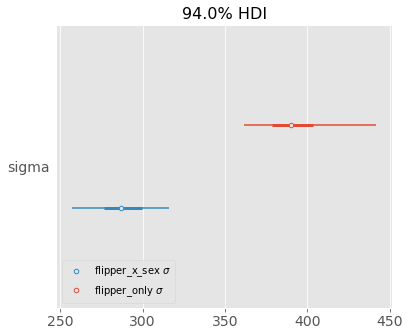

In [289]:
mcmc_multiple_az = az.from_pyro(mcmc)
mcmc_simple_az = az.from_pyro(mcmc_simple)

az.plot_forest([mcmc_simple_az, mcmc_multiple_az], var_names=['sigma'])
# manually specify to avoid confusion
plt.legend(['flipper_x_sex $\sigma$', 'flipper_only $\sigma$'])
plt.show()

### Counterfactuals

## Generalized Linear Models

### Logistic Regression

In [ ]:
species_filter = penguins['species'].isin(['Adelie', 'Chinstrap'])
bill_length_obs = torch.from_numpy(penguins.loc[species_filter, 'bill_length_mm'].values.reshape(-1, 1))
bill_length_obs = torch.tensor(bill_length_obs, dtype=torch.float)

species = pd.Categorical(penguins.loc[species_filter, 'species'])
species_codes = torch.from_numpy(species.codes).to(torch.float64)
species_codes = torch.tensor(species_codes, dtype=torch.float)

In [8]:
def logistic_model(bill_length, species=None):

    N, P = bill_length.shape

    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 10.).expand([P]))
    mu = beta_0 + torch.matmul(beta_1, bill_length.T) 
    theta = pyro.deterministic('theta', torch.sigmoid(mu))
    db = pyro.deterministic('db', -beta_0 / beta_1)

    with pyro.plate('plate'):
        y1 = pyro.sample('y1', dist.Bernoulli(theta), obs=species)

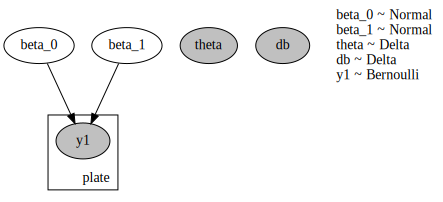

In [9]:
# we don't observe theta or db
pyro.render_model(
    logistic_model, 
    model_args=(bill_length_obs, species_codes),
    render_distributions=True)

### MCMC

In [10]:
kernel = NUTS(logistic_model, adapt_step_size=True)
mcmc_logistic = MCMC(kernel, num_samples=500, warmup_steps=300)
mcmc_logistic.run(bill_length=bill_length_obs, species=species_codes)

Sample: 100%|██████████| 800/800 [00:40, 19.70it/s, step size=2.26e-02, acc. prob=0.930]


In [11]:
mcmc_logistic.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0    -35.22      4.74    -35.19    -42.34    -27.55     85.09      1.03
 beta_1[0]      0.80      0.11      0.80      0.61      0.95     84.65      1.03

Number of divergences: 0


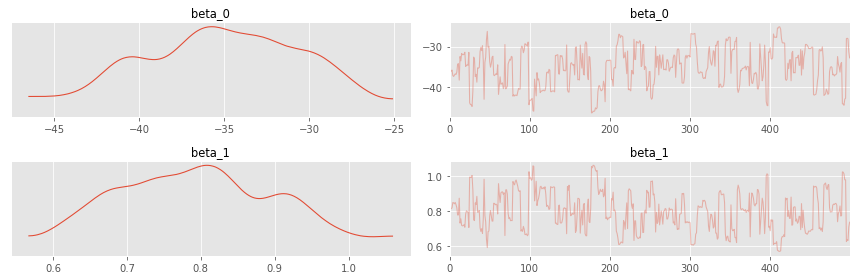

In [12]:
az.plot_trace(az.from_pyro(mcmc_logistic))
plt.tight_layout()

In [13]:
# latent variables
mcmc_samples = mcmc_logistic.get_samples(num_samples=1000)
# posterior samples 
predictive = Predictive(logistic_model, mcmc_samples)
# posterior predictive
predictive_samples = predictive(bill_length_obs, None) 

for k, v in predictive_samples.items():
    print(f'{k}: {tuple(v.shape)}')

y1: (1000, 214)
theta: (1000, 1, 214)
db: (1000, 1, 1)


In [14]:
prob_mu = predictive_samples['theta'].numpy().mean(axis=0).flatten()
prob_std = predictive_samples['theta'].numpy().std(axis=0).flatten()
db_mu = predictive_samples['db'].numpy().mean()
db_std = predictive_samples['db'].numpy().std()

predictions = pd.DataFrame({
    'bill_length': bill_length_obs.flatten(),
    'prob_mu': prob_mu,
    'prob_std': prob_std,
    'high': prob_mu + prob_std,
    'low': prob_mu - prob_std
})

predictions = predictions.sort_values(by=['bill_length'])

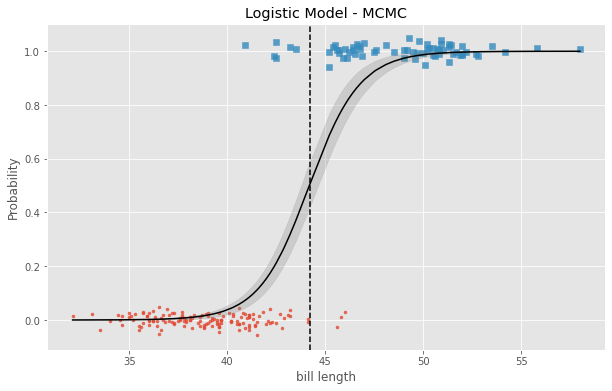

In [15]:
plt.figure(figsize=(10, 6))

for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i) ## size
    x = bill_length_obs[_filter] ## x_obs
    y = np.random.normal(i, 0.02, size=_filter.sum()) ## small amount of noise (jitter)
    plt.scatter(bill_length_obs[_filter], y, marker=marker, label=label, alpha=.8)

plt.plot(predictions['bill_length'], predictions['prob_mu'], color='black')
plt.fill_between(
    predictions['bill_length'], predictions['high'], predictions['low'],
    alpha=0.25, color='grey')
plt.axvline(
    x=predictive_samples['db'].numpy().mean(), linestyle='--', color='black')
plt.xlabel('bill length')
plt.ylabel('Probability')
plt.title('Logistic Model - MCMC')
plt.show()

### SVI

In [17]:
def logistic_guide(bill_length, species=None):

    N, P = bill_length.shape
    
    beta_0_loc = pyro.param('beta_0_loc', torch.tensor(0.))
    beta_0_scale = pyro.param('beta_0_scale', torch.tensor(0.1), constraint=constraints.positive)
    beta_0 = pyro.sample('beta_0', dist.Normal(beta_0_loc, beta_0_scale))

    beta_1_loc = pyro.param('beta_1_loc', torch.tensor(0.1))
    beta_1_scale = pyro.param('beta_1_scale', torch.tensor(0.1), constraint=constraints.positive)
    beta_1 = pyro.sample('beta_1', dist.Normal(beta_1_loc, beta_1_scale).expand([P]))

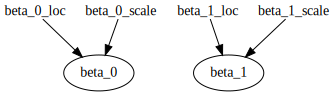

In [18]:
pyro.render_model(
    logistic_guide, 
    model_args=(bill_length_obs, species_codes), 
    render_params=True
    )

In [19]:
from pyro.optim import Adam

pyro.clear_param_store()

#guide = AutoLaplaceApproximation(logistic_model)
optim = Adam({"lr": 0.3})
svi = SVI(logistic_model, logistic_guide, optim, Trace_ELBO())

elbo_loss = []
for i in range(1000):
    loss = svi.step(bill_length_obs, species_codes)
    elbo_loss.append(loss)

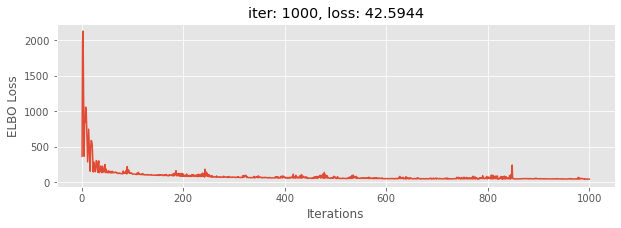

In [20]:
plt.figure(figsize=(10, 3))
plt.plot(np.arange(1, 1001), elbo_loss)
plt.ylabel('ELBO Loss')
plt.xlabel('Iterations')
plt.title(f'iter: 1000, loss: {np.min(elbo_loss):.4f}')
plt.show()

In [21]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

beta_0_loc tensor(-24.6493, requires_grad=True)
beta_0_scale tensor(0.2914, grad_fn=<AddBackward0>)
beta_1_loc tensor(0.5666, requires_grad=True)
beta_1_scale tensor(0.0053, grad_fn=<AddBackward0>)


In [22]:
predictive = Predictive(logistic_model, guide=logistic_guide, num_samples=1000)
posterior_svi_samples = predictive(bill_length_obs, None)

In [23]:
prob_mu = posterior_svi_samples['theta'].numpy().mean(axis=0).flatten()
prob_std = posterior_svi_samples['theta'].numpy().std(axis=0).flatten()
#db_mu = posterior_svi_samples['db'].numpy().mean()
#db_std = posterior_svi_samples['db'].numpy().std()

predictions = pd.DataFrame({
    'bill_length': bill_length_obs.flatten(),
    'prob_mu': prob_mu,
    'prob_std': prob_std,
    'high': prob_mu + prob_std,
    'low': prob_mu - prob_std
})

predictions = predictions.sort_values(by=['bill_length'])

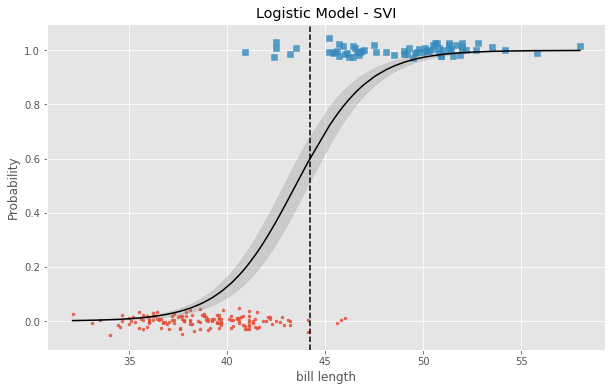

In [24]:
plt.figure(figsize=(10, 6))

for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i) ## size
    x = bill_length_obs[_filter] ## x_obs
    y = np.random.normal(i, 0.02, size=_filter.sum()) ## add small amount of noise for plotting
    plt.scatter(bill_length_obs[_filter], y, marker=marker, label=label, alpha=.8)

plt.plot(predictions['bill_length'], predictions['prob_mu'], color='black')
plt.fill_between(
    predictions['bill_length'], predictions['high'], predictions['low'],
    alpha=0.25, color='grey')
plt.axvline(
    x=predictive_samples['db'].numpy().mean(), linestyle='--', color='black')
plt.xlabel('bill length')
plt.ylabel('Probability')
plt.title('Logistic Model - SVI')
plt.show()

#### Code 3.23

Use body mass as a covariate

#### Code 3.24

Using body mass **and** flipper length as covariates

When creating a multidimensional distribution in pyro, there is the added functionality of `.to_event(1)`. This method implies that "these dimensions should be treated as a single event".
- see discussion [here](https://forum.pyro.ai/t/understanding-when-to-use-to-event-in-vae-tutorial/2380) 

In [309]:
dist.Normal(0., 20.).expand([2]).to_event(1)

Independent(Normal(loc: torch.Size([2]), scale: torch.Size([2])), 1)

In [310]:
X = penguins.loc[species_filter, ['bill_length_mm', 'body_mass_g']]
#X.insert(0, 'intercept', value=1)
X = torch.from_numpy(X.values)
species_codes = species_codes.reshape(-1, 1)

In [311]:
def multiple_logistic_model(data_matrix, species=None):

    N, K = data_matrix.size()

    beta = pyro.sample("b", dist.Normal(0, 10))
    w = pyro.sample('coef', dist.Normal(0., 20.).expand([K]))
    #w = pyro.sample('coef', dist.Normal(torch.zeros(K), torch.ones(K)))

    mu = beta + torch.mul(data_matrix, w)
    theta = pyro.deterministic('theta', torch.sigmoid(mu))
    #db = pyro.deterministic('db', ((-w[0] / w[2]) - (w[1] / w[2])) * data_matrix[:, 1])

    with pyro.plate('plate'):
        y1 = pyro.sample('obs', dist.Bernoulli(theta), obs=species)

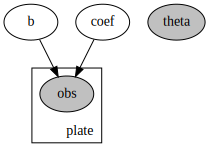

In [312]:
pyro.render_model(
    multiple_logistic_model, model_args=(X, species_codes)
    )

In [313]:
kernel = NUTS(model=multiple_logistic_model, adapt_step_size=True)
mcmc_mult_logistic = MCMC(kernel, num_samples=1200, warmup_steps=500)
mcmc_mult_logistic.run(X, species_codes)

Sample: 100%|██████████| 1700/1700 [00:17, 94.46it/s, step size=2.26e-01, acc. prob=0.750] 


In [314]:
mcmc_mult_logistic.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.02     10.20      0.14    -15.60     16.55    119.77      1.00
   coef[0]    -16.17     11.70    -14.33    -32.86     -0.66    135.29      1.00
   coef[1]    -18.33     13.70    -15.16    -39.46     -0.04     68.52      1.00

Number of divergences: 1041


In [315]:
mcmc_mult_samples = mcmc_mult_logistic.get_samples(num_samples=1000)
post_predictive = Predictive(multiple_logistic_model, mcmc_mult_samples)
predictive_samples = post_predictive(X, None)

for k, v in predictive_samples.items():
    print(f'{k}: {tuple(v.shape)}')

obs: (1000, 214, 2)
theta: (1000, 1, 214, 2)


In [316]:
inf_data = az.from_pyro(
    mcmc_mult_logistic,
    posterior_predictive=mcmc_mult_samples
)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.
posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


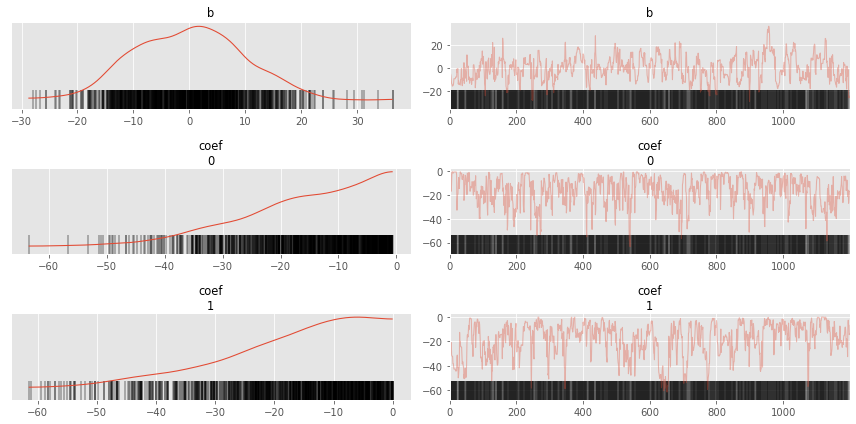

In [317]:
az.plot_trace(inf_data, compact=False, var_names=['b', 'coef'])
plt.tight_layout()
plt.show()

In [318]:
az.summary(inf_data, var_names=['b', 'coef'])

arviz - WARNING - Shape validation failed: input_shape: (1, 1200), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.018,10.196,-18.098,18.778,0.933,0.661,123.0,201.0,NaN
coef[0],-16.169,11.696,-36.743,-0.661,0.993,0.703,122.0,164.0,NaN
coef[1],-18.328,13.697,-44.123,-0.043,1.722,1.223,61.0,101.0,NaN


In [319]:
prob_mu = predictive_samples['theta'].mean(axis=0)[0][:, 0]
prob_std = predictive_samples['theta'].std(axis=0)[0][:, 0]
#db_mu = predictive_samples['db'].numpy().mean()
#db_std = predictive_samples['db'].numpy().std()

predictions = pd.DataFrame({
    'bill_length': X[:, 0].numpy(),
    'mass': X[:, 1].numpy(),
    'prob_mu': prob_mu,
    'prob_std': prob_std,
    'high': prob_mu + prob_std,
    'low': prob_mu - prob_std
})

predictions = predictions.sort_values(by=['bill_length', 'mass'])

In [320]:
predictions

,bill_length,mass,prob_mu,prob_std,high,low
136,32.1,3050.0,3.537150e-16,5.096275e-15,5.449990e-15,-4.742560e-15
92,33.1,2900.0,1.517540e-16,2.213480e-15,2.365234e-15,-2.061726e-15
64,33.5,3600.0,1.082795e-16,1.586066e-15,1.694345e-15,-1.477787e-15
86,34.0,3400.0,7.106088e-17,1.045858e-15,1.116918e-15,-9.747967e-16
13,34.4,3325.0,5.076441e-17,7.496711e-16,8.004355e-16,-6.989067e-16
...,...,...,...,...,...,...
175,52.8,4550.0,2.214820e-23,4.308487e-22,4.529969e-22,-4.087005e-22
185,53.5,4500.0,1.326296e-23,2.669512e-22,2.802142e-22,-2.536883e-22
177,54.2,4300.0,7.970474e-24,1.659051e-22,1.738756e-22,-1.579347e-22
209,55.8,4000.0,2.520593e-24,5.642782e-23,5.894841e-23,-5.390723e-23
